In [362]:
import pandas as pd
import numpy as np
import itertools
import glob
import datetime
import re
import multiprocess
from sklearn import model_selection, preprocessing

import matplotlib.pyplot as plt

import keras

%matplotlib inline

In [65]:
movie_files = glob.glob('/Users/frjo6001/Downloads/download/training_set/*.txt')

def netflix_data_parse( file_path ):
    txt = open(file_path,'r').read()
    
    movie_id = int(re.findall('(\d+)\:',txt)[0])
    
    rating  = re.findall('(\d+)\,(\d)\,[\d\-]*\n',txt)
    rating = [(int(v[0]), int(v[1])) for v in rating]
    
    df = pd.DataFrame(data=rating, columns=['personID','rating'])
    df['movieID'] = movie_id
    
    return df[['personID','movieID','rating']]

pool = multiprocess.Pool()
parse = pool.map(netflix_data_parse, movie_files)
pool.close()

df = pd.concat(parse)

2.35


In [8]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.3); del df

In [69]:
person_test = set(df_test.personID.unique())
movie_test  = set(df_test.movieID.unique())

person_train = set(df_train.personID.unique())
movie_train  = set(df_train.movieID.unique())

p_intersect = person_test.intersection(person_train)
m_intersect = movie_test.intersection(movie_train)

In [70]:
df_test = df_test[ df_test.personID.isin(p_intersect) & (df_test.movieID.isin(m_intersect))]

In [85]:
m_le = preprocessing.LabelEncoder().fit( list(p_intersect.union(person_train)) )
p_le = preprocessing.LabelEncoder().fit( list(m_intersect.union(movie_train)) )

df_test.movieID = p_le.transform(df_test.movieID)
df_train.movieID = p_le.transform(df_train.movieID)
df_test.personID = m_le.transform(df_test.personID)
df_train.personID = m_le.transform(df_train.personID)

In [140]:
embeding_size = 12

inp_movie = keras.layers.Input((1,),name='movie')
inp_person = keras.layers.Input((1,),name='person')

p_embed = keras.layers.Embedding(p_le.classes_.shape[0], embeding_size, input_length=1)(inp_person)
m_embed = keras.layers.Embedding(m_le.classes_.shape[0], embeding_size, input_length=1)(inp_movie)


x = keras.layers.dot([p_embed, m_embed],-1)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)

model = keras.models.Model(inputs=[inp_movie,inp_person], outputs=[x])

model.compile(loss=keras.losses.MSE, 
              optimizer=keras.optimizers.Adam()
             )

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
person (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 1, 12)        213240      person[0][0]                     
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 1, 12)        5753964     movie[0][0]                      
__________________________________________________________________________________________________
dot_5 (Dot

In [142]:
model.fit(x={'person':np.atleast_2d(df_train.movieID.values).T, 
             'movie':np.atleast_2d(df_train.personID.values).T},
          y=df_train.rating,
          batch_size=100000,
          epochs=5,
          validation_data = ({'person':np.atleast_2d(df_test.movieID.values).T, 
             'movie':np.atleast_2d(df_test.personID.values).T},df_test.rating )
         )

Train on 70336354 samples, validate on 30143058 samples
Epoch 1/5
70336354/70336354 [==============================] - 88s 1us/step - loss: 8.5882 - val_loss: 6.8625
Epoch 2/5
70336354/70336354 [==============================] - 89s 1us/step - loss: 5.5449 - val_loss: 4.3690
Epoch 3/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 3.4386 - val_loss: 2.6800
Epoch 4/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 2.0652 - val_loss: 1.6288
Epoch 5/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 1.2560 - val_loss: 1.0581


<p> Our loss is still falling, lets train for a few more epochs.</p>

In [143]:
model.fit(x={'person':np.atleast_2d(df_train.movieID.values).T, 
             'movie':np.atleast_2d(df_train.personID.values).T},
          y=df_train.rating,
          batch_size=100000,
          epochs=5,
          validation_data = ({'person':np.atleast_2d(df_test.movieID.values).T, 
             'movie':np.atleast_2d(df_test.personID.values).T},df_test.rating )
         )

Train on 70336354 samples, validate on 30143058 samples
Epoch 1/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 0.8496 - val_loss: 0.8082
Epoch 2/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 0.6903 - val_loss: 0.7304
Epoch 3/5
70336354/70336354 [==============================] - 91s 1us/step - loss: 0.6466 - val_loss: 0.7167
Epoch 4/5
70336354/70336354 [==============================] - 91s 1us/step - loss: 0.6383 - val_loss: 0.7163
Epoch 5/5
70336354/70336354 [==============================] - 90s 1us/step - loss: 0.6359 - val_loss: 0.7166


In [160]:
model.save('/Users/frjo6001/Desktop/embeding_model.hdf5')

In [335]:
movie_embeddings = model.get_layer('embedding_55').get_weights()[0]
movie_embeddings = movie_embeddings/np.atleast_2d(np.linalg.norm(movie_embeddings,axis=1)).T

In [314]:
mv = open('/Users/frjo6001/Downloads/download/movie_titles.txt','r',encoding='latin1').readlines()
data = [re.findall('(\d+),(\d+),([\w\s\,\:]+)',v.strip('\n')) for v in mv]

In [315]:
mv_df = pd.read_csv('/Users/frjo6001/Downloads/download/movie_titles.txt',encoding='latin1',
                    error_bad_lines=False, warn_bad_lines=False, names=['movieID','year','title'])
mv_df['movieID'] = movie_enc.transform(mv_df.movieID)

### Movie simularity search 
<p>I love "The Terminator" movie franchise. Which movies are most simular?</p> 

In [357]:
mv_df[mv_df.title.str.contains('the terminator',case=False)]

,movieID,year,title
6195,6195,1984.0,The Terminator


In [347]:
target = movie_embeddings[6195]
mv_df[ mv_df.movieID.isin(np.argsort( movie_embeddings.dot(target) )[::-1][1:11]) ]


,movieID,year,title
797,797,1975.0,Jaws
1624,1624,1986.0,Aliens: Collector's Edition
2429,2429,1979.0,Alien: Collector's Edition
3948,3948,1991.0,Terminator 2: Extreme Edition: Bonus Material
7700,7700,1981.0,The Road Warrior
8106,8106,1987.0,Predator: Collector's Edition
8914,8914,1991.0,Terminator 2: Extreme Edition
9959,9959,1988.0,Die Hard
14108,14108,1990.0,Total Recall
14311,14311,1993.0,Jurassic Park


<p>My niece loves "Totoro", which movies are most simular to that?</p>

In [351]:
mv_df[mv_df.title.str.contains('totoro',case=False)]

,movieID,year,title
3592,3592,1988.0,My Neighbor Totoro


In [356]:
target = movie_embeddings[17713]
mv_df[ mv_df.movieID.isin(np.argsort( movie_embeddings.dot(target) )[::-1][1:11]) ]


,movieID,year,title
1881,1881,1954.0,I Love Lucy: Season 4
2017,2017,2005.0,Classic Cartoon Favorites: Starring Goofy
2798,2798,2005.0,Johnny Cash: Ridin' the Rails: The Great Ameri...
4307,4307,1999.0,Beauty and the Beast
4574,4574,1969.0,Scooby-Doo Where Are You?: Seasons 1 & 2
7988,7988,1991.0,Beauty and the Beast: Special Edition
8420,8420,2002.0,Bear in the Big Blue House: Dance Party!
9701,9701,1999.0,Tarzan
10465,10465,1955.0,Lady and the Tramp
17425,17425,1953.0,Peter Pan


In [358]:
from sklearn import manifold

In [359]:
tsne = manifold.TSNE()
x = tsne.fit_transform(movie_embeddings)

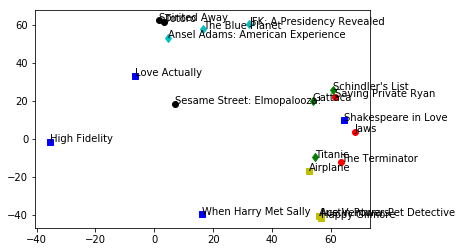

In [516]:
action    = {"Saving Private Ryan":17156,'The Terminator':6195, "Jaws":797}
romCom    = {"Love Actually":4471,"When Harry Met Sally":11849,"Shakespeare in Love":17763,"High Fidelity":311}
acadmey   = {"Titanic":16878,"Schindler's List":12869,"Gattaca":17761}
slapstick = {"Ace Ventura: Pet Detective":10927,"Austin Powers":13194,"Airplane":11397,"Happy Gilmore":8763}
animated     = {"Totoro":3592, "Spirited Away":3445, "Sesame Street: Elmopalooza!":6670}
doccumentry ={"The Blue Planet":8663,"JFK: A Presidency Revealed":5602,"Ansel Adams: American Experience":2295}

for k,v in action.items(): plt.plot(x[v,0],x[v,1], 'ro'); plt.annotate(s=k, xy=x[v])
for k,v in romCom.items(): plt.plot(x[v,0],x[v,1], 'bs'); plt.annotate(s=k, xy=x[v])
for k,v in acadmey.items(): plt.plot(x[v,0],x[v,1], 'gd'); plt.annotate(s=k, xy=x[v])
for k,v in slapstick.items(): plt.plot(x[v,0],x[v,1], 'ys'); plt.annotate(s=k, xy=x[v])
for k,v in animated.items(): plt.plot(x[v,0],x[v,1], 'ko'); plt.annotate(s=k, xy=x[v])
for k,v in doccumentry.items(): plt.plot(x[v,0],x[v,1], 'cd'); plt.annotate(s=k, xy=x[v])


In [ ]:
for k,v in myMovies.items(): plt.plot(x[v,0],x[v,1], 'ro'); plt.annotate

In [519]:
mv_df[ mv_df.title.str.contains('American Exp', case=False)]


,movieID,year,title
1256,1256,2003.0,Tupperware!: American Experience
1685,1685,1998.0,Riding the Rails: American Experience
2137,2137,2003.0,Bataan Rescue: American Experience
2295,2295,2002.0,Ansel Adams: American Experience
2570,2570,2002.0,Woodrow Wilson: American Experience
3622,3622,2002.0,Daughter from Danang: American Experience
4657,4657,2003.0,Seabiscuit: American Experience
5313,5313,1999.0,Return with Honor: American Experience
7040,7040,2003.0,The Murder of Emmett Till: American Experience
9464,9464,2004.0,The Fight: American Experience
